In [1664]:
from manifold_learning import IMD
import numpy as np
from FastCCM import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand,load_csv_dataset,load_traffic_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from manifold_learning import imd_nd_smap
import importlib
importlib.reload(imd_nd_smap)

<module 'manifold_learning.imd_nd_smap' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/imd_nd_smap.py'>

In [1495]:
# Load traffic dataset
X = load_traffic_dataset()
page_names = X["Page"].to_numpy().astype("str")
X = X[X.columns[1:]]

df = X.T

# Interpolate missing values
df_interpolated = df.interpolate(method='linear', limit_direction='forward', axis=0)

# Fill any remaining missing values with zeros
df_filled = df_interpolated.fillna(0)
X = df_filled.to_numpy().astype(np.float32)


X = np.log(X+1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
page_names = page_names[X.mean(axis=0) != 0]
X = X[:,X.mean(axis=0) != 0]
X = (X-X.mean(axis=0))/X.std(axis=0)

mask = (np.count_nonzero(np.diff(X[:,:],axis=0),axis=0) > 750)
X = X[:,mask]
page_names = page_names[mask]
observables = StandardScaler().fit_transform(X)

In [432]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

In [1556]:
X = get_truncated_lorenz_rand(400,n_steps=20000)

In [1736]:
X = load_csv_dataset("Jan1023_1_fr_ma2sec_sr30.csv").to_numpy()[:,1:]
#X = utils.get_td_embedding_np(X,5,20).reshape(-1,5*X.shape[1])

observables = StandardScaler().fit_transform(X)

In [1557]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),6), np.linspace(X[:,2].min(),X[:,2].max(),6))).reshape(2,-1).T

In [1558]:
X_ = [get_truncated_lorenz_rand(400,n_steps=20000)[:,[0,2]] for i in range(5)]
observables = np.concatenate([np.array([gaussian_kernel(x,e,sigma=15) for e in exp_kernel_grid]) for x in X_]).T

observables = StandardScaler().fit_transform(observables)

In [1912]:
trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=3, n_components=6,subtract_corr=True, device="cuda")


In [1954]:
trainer.fit(observables, sample_len=70, library_len=700, 
            exclusion_rad=90, omega=5, tp=90, 
            epochs=1000, num_batches=16, optimizer="Adam", learning_rate=0.01,tp_policy="range")


Epoch 1/1000, Loss: 0.8355
Epoch 2/1000, Loss: 0.8226
Epoch 3/1000, Loss: 0.8299
Epoch 4/1000, Loss: 0.8399
Epoch 5/1000, Loss: 0.8351
Epoch 6/1000, Loss: 0.8303
Epoch 7/1000, Loss: 0.8283
Epoch 8/1000, Loss: 0.8187
Epoch 9/1000, Loss: 0.8390
Epoch 10/1000, Loss: 0.8100
Epoch 11/1000, Loss: 0.8218
Epoch 12/1000, Loss: 0.8389
Epoch 13/1000, Loss: 0.8325
Epoch 14/1000, Loss: 0.8411
Epoch 15/1000, Loss: 0.8375
Epoch 16/1000, Loss: 0.8368
Epoch 17/1000, Loss: 0.8214
Epoch 18/1000, Loss: 0.8381
Epoch 19/1000, Loss: 0.8362
Epoch 20/1000, Loss: 0.8397
Epoch 21/1000, Loss: 0.8416
Epoch 22/1000, Loss: 0.8321
Epoch 23/1000, Loss: 0.8299
Epoch 24/1000, Loss: 0.8353
Epoch 25/1000, Loss: 0.8230
Epoch 26/1000, Loss: 0.8312
Epoch 27/1000, Loss: 0.8322
Epoch 28/1000, Loss: 0.8303
Epoch 29/1000, Loss: 0.8293
Epoch 30/1000, Loss: 0.8409
Epoch 31/1000, Loss: 0.8270
Epoch 32/1000, Loss: 0.8268
Epoch 33/1000, Loss: 0.8334
Epoch 34/1000, Loss: 0.8323
Epoch 35/1000, Loss: 0.8230
Epoch 36/1000, Loss: 0.8200
E

KeyboardInterrupt: 

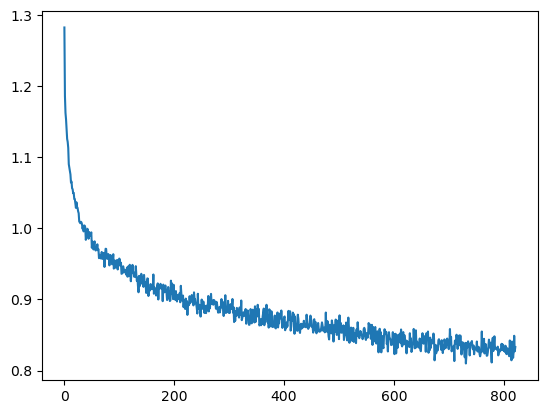

In [1955]:
plt.plot(trainer.get_loss_history()[:])


In [1956]:

unmixed = trainer.predict(observables)

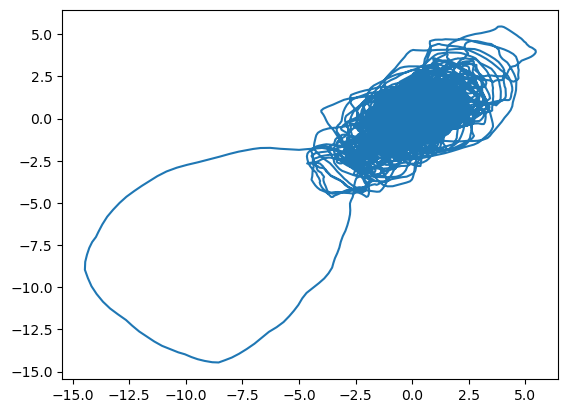

In [1957]:
plt.plot(unmixed[20:,0,2],unmixed[:-20,0,2])

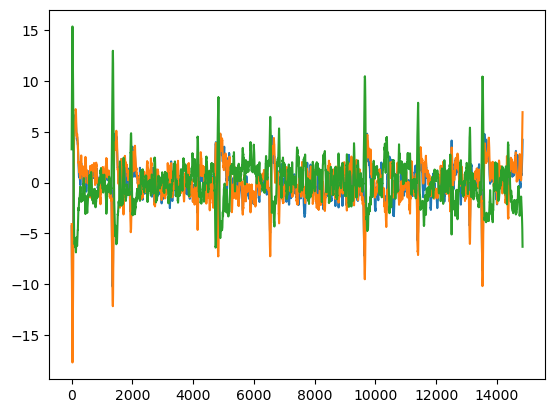

In [1958]:

plt.plot(unmixed[:,5,:])

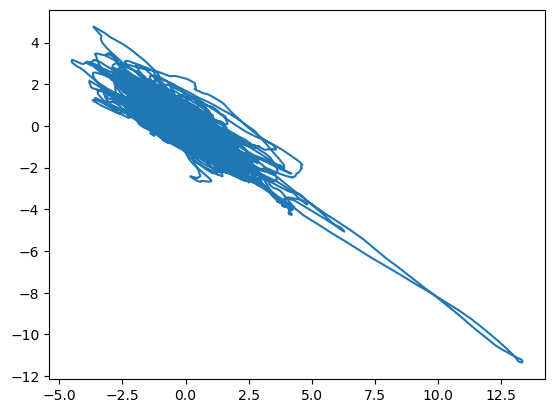

In [1959]:
plt.plot(unmixed[:,0,1], unmixed[:,0,0])

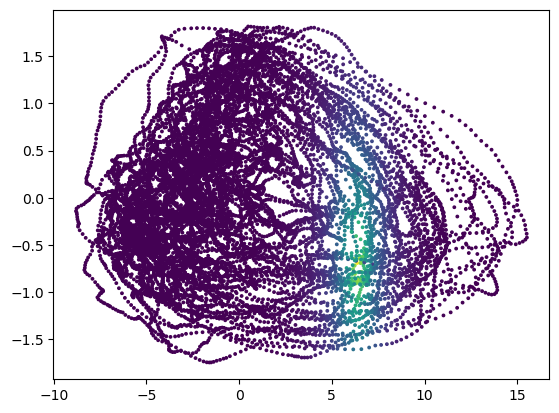

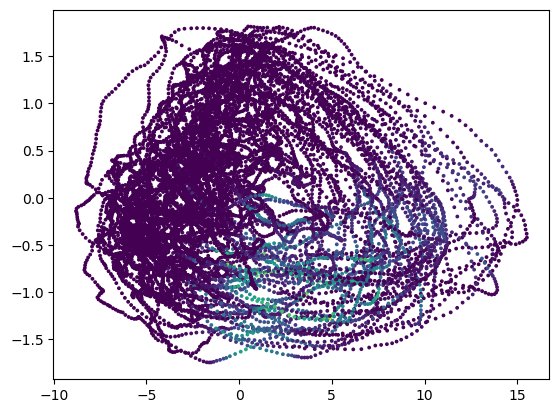

In [1960]:
from sklearn.metrics import pairwise_distances

dist = pairwise_distances(unmixed[:,4][[3250]],unmixed[:,4])[0]
weights = np.exp(-(1*dist))

x_pca = PCA(2).fit_transform(unmixed[:,4,:])
plt.scatter(x_pca[:-20,0],x_pca[:-20,1],c=weights[:-20],s=3)
plt.show()

x_pca = PCA(2).fit_transform(unmixed[:,4,:])
plt.scatter(x_pca[20:,0],x_pca[20:,1],c=weights[:-20],s=3)

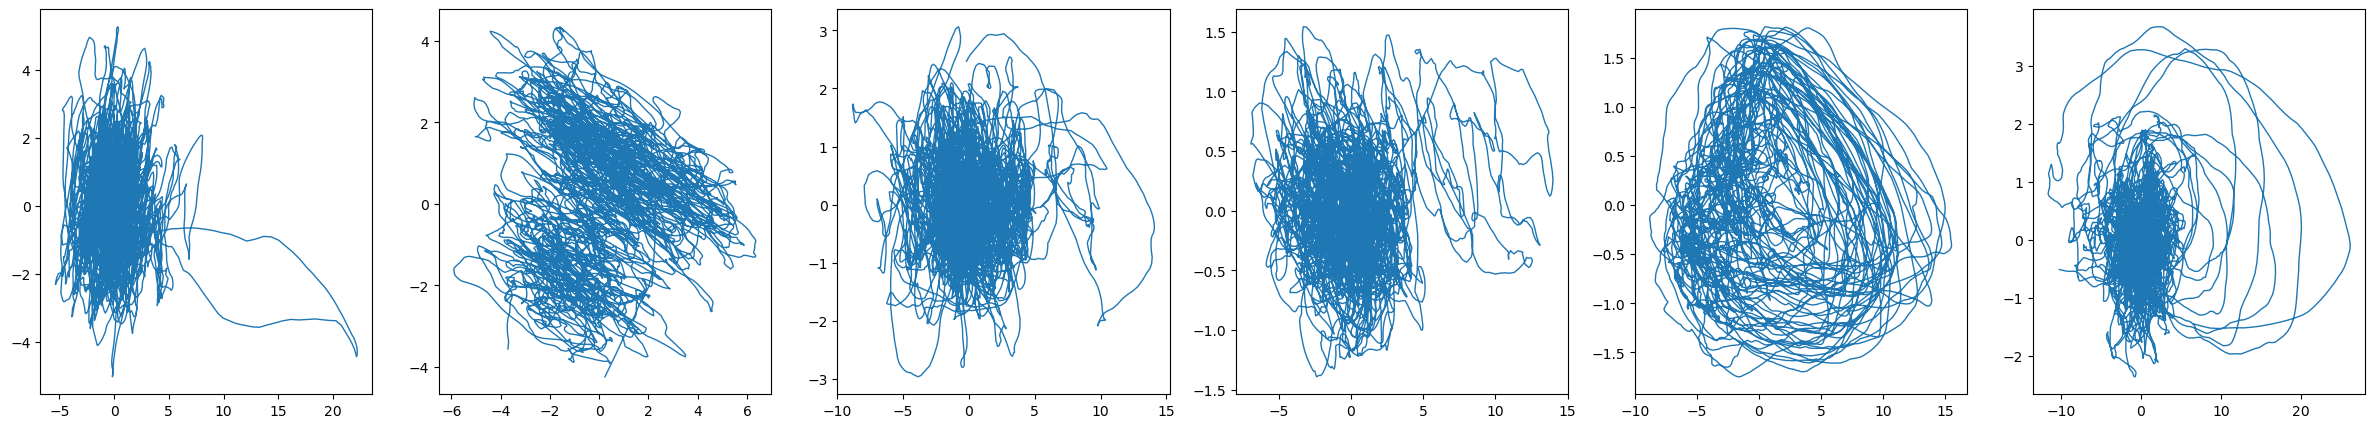

In [1961]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=1)

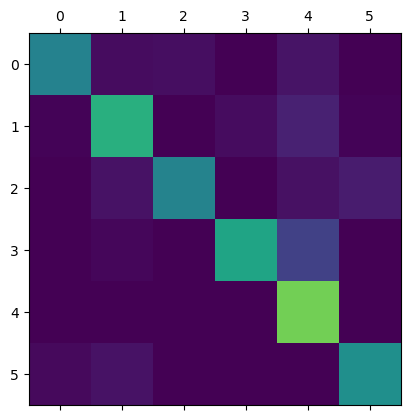

In [1962]:
plt.matshow(CCM.PairwiseCCM().compute(np.transpose(unmixed,axes=(1,0,2)),np.transpose(unmixed,axes=(1,0,2)),1500,400,60,30,90,False).mean(axis=0),vmin=0,vmax=1)

In [1963]:
import plotly.express as px
x_pca = PCA(3).fit_transform(unmixed[:,0,:])
fig = px.line_3d(x=x_pca[:,0], y=x_pca[:,1],z=x_pca[:,2],height=700)

fig.show()

In [1945]:
fig = px.line_3d(x=unmixed[:,0,0], y=unmixed[:,0,1],z=unmixed[:,0,2],height=700)

fig.show()